# CL term structure research

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib nbagg

In [2]:
import glob
from collections import defaultdict
import datetime

### Prepare the data

In [3]:
PATH_TO_DATA = 'Q:/MSK1_QR/HistoricalData/Futures/CalendarDaily/'
files = glob.glob(PATH_TO_DATA + '*.csv')
symbols = map(lambda z: z[49:-4], files)

In [4]:
' '.join(symbols)

'CLF06 CLF07 CLF08 CLF09 CLF10 CLF11 CLF12 CLF13 CLF14 CLF15 CLF16 CLF17 CLG06 CLG07 CLG08 CLG09 CLG10 CLG11 CLG12 CLG13 CLG14 CLG15 CLG16 CLG17 CLH06 CLH07 CLH08 CLH09 CLH10 CLH11 CLH12 CLH13 CLH14 CLH15 CLH16 CLH17 CLJ06 CLJ07 CLJ08 CLJ09 CLJ10 CLJ11 CLJ12 CLJ13 CLJ14 CLJ15 CLJ16 CLJ17 CLK06 CLK07 CLK08 CLK09 CLK10 CLK11 CLK12 CLK13 CLK14 CLK15 CLK16 CLK17 CLM06 CLM07 CLM08 CLM09 CLM10 CLM11 CLM12 CLM13 CLM14 CLM15 CLM16 CLM17 CLN06 CLN07 CLN08 CLN09 CLN10 CLN11 CLN12 CLN13 CLN14 CLN15 CLN16 CLN17 CLQ06 CLQ07 CLQ08 CLQ09 CLQ10 CLQ11 CLQ12 CLQ13 CLQ14 CLQ15 CLQ16 CLQ17 CLU06 CLU07 CLU08 CLU09 CLU10 CLU11 CLU12 CLU13 CLU14 CLU15 CLU16 CLU17 CLV06 CLV07 CLV08 CLV09 CLV10 CLV11 CLV12 CLV13 CLV14 CLV15 CLV16 CLV17 CLX06 CLX07 CLX08 CLX09 CLX10 CLX11 CLX12 CLX13 CLX14 CLX15 CLX16 CLX17 CLZ06 CLZ07 CLZ08 CLZ09 CLZ10 CLZ11 CLZ12 CLZ13 CLZ14 CLZ15 CLZ16 CLZ17'

In [5]:
market_data = defaultdict()
for filename, sym in zip(files, symbols):
    market_data[sym] = pd.read_csv(filename, parse_dates=['Date'], index_col='Date').drop('Time', axis = 1)

In [6]:
expirations = defaultdict()
for sym in symbols:
    expirations[sym] = market_data[sym].index[-1]

In [7]:
contract = pd.read_csv('Q:/MSK1_QR/HistoricalData/Futures/QCL#.csv',\
                       parse_dates=['Date'], index_col='Date').drop('Time', axis = 1)

In [8]:
contract = contract[contract.index > market_data['CLF06'].index[-10]]

In [9]:
#fed_r = pd.read_csv('../FEDFUNDS.csv', parse_dates=['DATE'], index_col='DATE')
fed_r = pd.read_csv('Q:/MSK1_QR/HistoricalData/FED_RATE.csv', parse_dates=['Date'], index_col='Date')
fed_r = fed_r[fed_r.index > market_data['CLF06'].index[-10]]
fed_r = pd.concat([fed_r, contract], axis = 1).rate
fed_r = fed_r.ffill().bfill()
fed_r.head()

Date
2005-12-08    4.00
2005-12-09    4.00
2005-12-12    4.00
2005-12-13    4.25
2005-12-14    4.25
Name: rate, dtype: float64

In [10]:
time_arg = contract.index

In [11]:
pnl = pd.read_csv('Q:/MSK1_QR/HistoricalData/CS_CL.csv', parse_dates=['Date'], index_col='Date')

In [12]:
pnl = pd.concat([pnl, contract], axis = 1).pnl
pnl = pnl.ffill().bfill()

In [13]:
strategy = pd.read_csv('Q:/MSK1_QR/Strategies/CalendarSpread/CalendarSpreadBT/CalendarSpreadStrat181116wh.csv', \
                      parse_dates = ['d1','d2','d3'])
strategy = strategy[['contract1', 'contract2', 'contract3', 'contract4', 'd1', 'd2', 'd3']]
def contract_name_edit(contract):    
    return map(lambda z: 'CL' + z, contract)

    
strategy.contract1 = contract_name_edit(strategy.contract1)
strategy.contract2 = contract_name_edit(strategy.contract2)
strategy.contract3 = contract_name_edit(strategy.contract3)
strategy.contract4 = contract_name_edit(strategy.contract4)

contract1                  CLG08
contract2                  CLM08
contract3                  CLG08
contract4                  CLN08
d1           2007-12-01 00:00:00
d2           2007-12-31 00:00:00
d3           2007-12-18 00:00:00
Name: 23, dtype: object


In [50]:
time_arg[500]

Timestamp('2007-12-04 00:00:00')

### Visualization

In [14]:
def get_by_index(df, index):
    try:
        return df['Close'].loc[index]
    except KeyError:
        return np.nan

def get_term_structure(t):
    spot = contract.Close.loc[t]
    ts = map(lambda sym: get_by_index(market_data[sym] - spot, t), symbols)
    ts = [(time_to, price) for (time_to, price) in \
             sorted(zip(map(lambda sym: int((expirations[sym] - t).days), symbols), ts)) if price is not np.nan and time_to < 500]
    time_to = map(lambda z: z[0], ts)
    price = map(lambda z: z[1], ts) 
    return time_to, price


In [21]:
def get_strategy_ts(t):
    
    spot = contract.Close.loc[t]
    df = strategy.copy()
    df = df[df.d1 < t]
    if df.shape[0] == 0:
        return ([], [])
    df = df.iloc[-1]
    t1 = df.d1
    t2 = df.d3 - datetime.timedelta(days = 5)
    t3 = df.d3
    t4 = df.d2
    
    if t > t1 and t <= t2:
        return ([int((expirations[df.contract1] - t).days), int((expirations[df.contract2] - t).days)], \
                [get_by_index(market_data[df.contract1], t) - spot, get_by_index(market_data[df.contract2], t) - spot])   
    elif t > t3 and t <= t4:
        return ([int((expirations[df.contract3] - t).days), int((expirations[df.contract4] - t).days)], \
                [get_by_index(market_data[df.contract3], t) - spot, get_by_index(market_data[df.contract4], t) - spot])    
    else:
        return ([], [])

get_strategy_ts(time_arg[500])

([49, 168], [-0.20999999999999375, -1.1299999999999955])

<IPython.core.display.Javascript object>


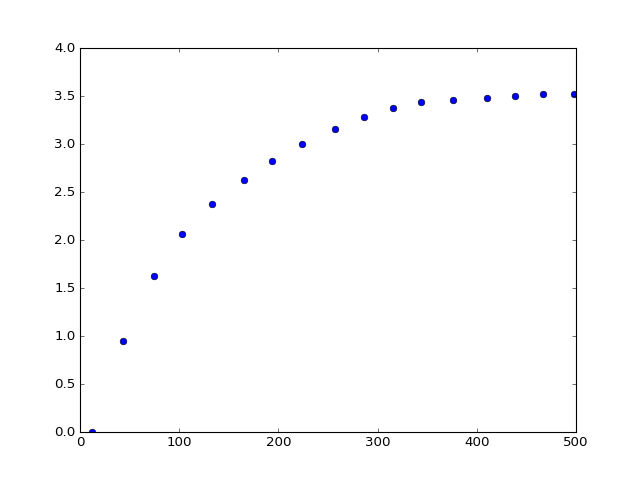

In [14]:
ts = get_term_structure(time_arg[0])
plt.plot(ts[0], ts[1], 'o')

In [15]:
'''import matplotlib.pyplot as plt
#%matplotlib nbagg
#import seaborn as sns
import matplotlib.animation as animation
import numpy as np


fig=plt.figure()
img, = plt.plot(ts[0], ts[1], linestyle='--', marker='o')
ax = plt.axes()
ax.set_ylim([-10.,10.])
ttl = ax.set_title('',animated=True)
ttl = ax.text(.2, 1.005, '', transform = ax.transAxes)

def init():
    ttl.set_text(str(time_arg[0].date()))
    ts_n = get_term_structure(time_arg[0])
    img.set_data(ts[0],ts[1])
    return img, ttl

def func(n):
    ttl.set_text('Date: {}, FED rate:{}, CL price: {}.'.format(time_arg[n].date(), get_fed_rate(time_arg[n]), \
                                                              contract.Close[time_arg[n]]))
    ts_n = get_term_structure(time_arg[n])
    img.set_data(ts_n[0],ts_n[1])
    return img, ttl

ani = animation.FuncAnimation(fig, func, init_func=init, frames=len(time_arg), interval=30, blit=True)

plt.show()'''

"import matplotlib.pyplot as plt\n#%matplotlib nbagg\n#import seaborn as sns\nimport matplotlib.animation as animation\nimport numpy as np\n\n\nfig=plt.figure()\nimg, = plt.plot(ts[0], ts[1], linestyle='--', marker='o')\nax = plt.axes()\nax.set_ylim([-10.,10.])\nttl = ax.set_title('',animated=True)\nttl = ax.text(.2, 1.005, '', transform = ax.transAxes)\n\ndef init():\n    ttl.set_text(str(time_arg[0].date()))\n    ts_n = get_term_structure(time_arg[0])\n    img.set_data(ts[0],ts[1])\n    return img, ttl\n\ndef func(n):\n    ttl.set_text('Date: {}, FED rate:{}, CL price: {}.'.format(time_arg[n].date(), get_fed_rate(time_arg[n]),                                                               contract.Close[time_arg[n]]))\n    ts_n = get_term_structure(time_arg[n])\n    img.set_data(ts_n[0],ts_n[1])\n    return img, ttl\n\nani = animation.FuncAnimation(fig, func, init_func=init, frames=len(time_arg), interval=30, blit=True)\n\nplt.show()"

<IPython.core.display.Javascript object>


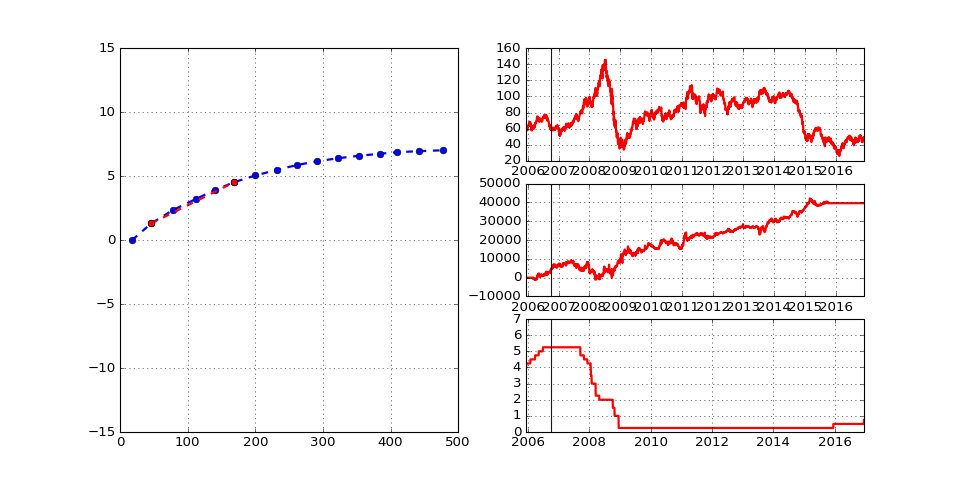

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
import matplotlib.animation as animation
from matplotlib import gridspec
plt.rcParams["figure.figsize"] = (12, 6)

def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < len(time_arg):
        cnt += 1
        t += 1
        ts_n = get_term_structure(time_arg[t])
        yield t, ts_n[0], ts_n[1]

data_gen.t = 0

# create a figure with two subplots
#fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig = plt.figure()
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[:, 0])


ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,1])

#ax4 = fig.add_subplot(2, 2, 6)


# intialize two line objects (one in each axes)
my_plt1, = ax1.plot([], [], lw=2, linestyle='--', marker='o')
my_plt11, = ax1.plot([], [], lw=2, linestyle='--', marker='o', color = 'r')

ax2.plot(list(contract.index), list(contract.Close), lw=2, color='r')
my_plt2, = ax2.plot((time_arg[0], time_arg[0]), (20, 160), color = 'black', alpha=0.9)
ax3.plot(list(pnl.index), list(pnl), lw=2, color='r')
my_plt3, = ax3.plot((time_arg[0], time_arg[0]), (0, 40000), color = 'black', alpha=0.9)
ax4.plot(list(fed_r.index), list(fed_r), lw=2, color='r')
my_plt4, = ax4.plot((time_arg[0], time_arg[0]), (0, 7.), color = 'black', alpha=0.9)
my_plt = [my_plt1, my_plt2, my_plt3, my_plt4]

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

# the same axes initalizations as before (just now we do it for both of them)
ax1.set_ylim([-15.,15.])
ax1.set_xlim([0,500])

def run(data):
    # update the data
    t, x, y = data
    strat_points = get_strategy_ts(time_arg[t])
    print strat_points
    #print strat_points
    # update the data of both line objects
    my_plt1.set_data(x, y)
    my_plt11.set_data(strat_points[0], strat_points[1])
    my_plt2.set_data((time_arg[t], time_arg[t]), (20, 160))  
    my_plt3.set_data((time_arg[t], time_arg[t]), (-10000, 50000))
    my_plt4.set_data((time_arg[t], time_arg[t]), (0, 7.))
    #ax2.plot((time_arg[t], time_arg[t]), (20, 160), 'k-', color = 'black', alpha=0.01)
    return my_plt

ani = animation.FuncAnimation(fig, run, data_gen, interval=30, blit=False,
    repeat=False)
plt.show()

In [75]:
get_strategy_ts(time_arg[50])

([61.009999999999998, 64.739999999999995], [27, 181])

In [76]:
time_arg[50]

Timestamp('2006-02-22 00:00:00')

<IPython.core.display.Javascript object>


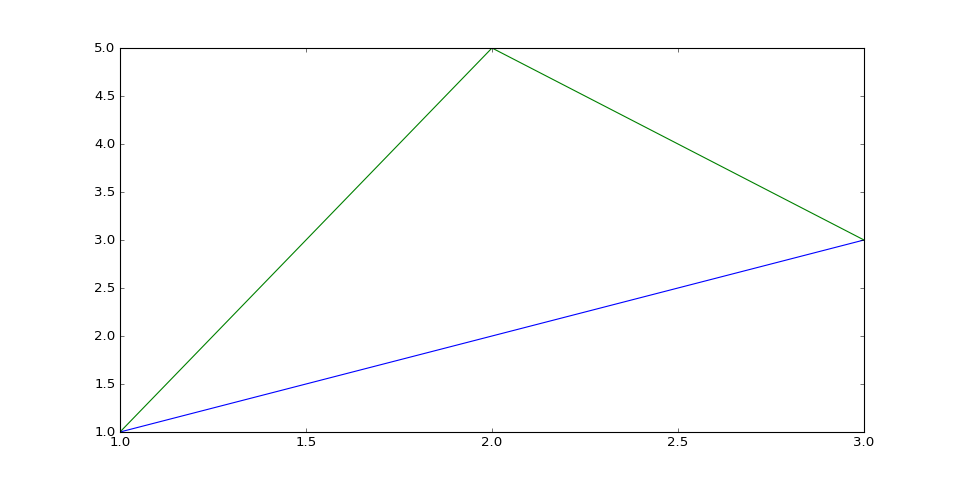

In [87]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot([1,2,3],[1,2,3])
ax.plot([1,2,3],[1,5,3])